LSTM modelado para predecir la potencia generada del PV (salida)
basado en 5 variables (entrada). P/un ejemplo parecido ver ->  https://youtu.be/tepxdcepTbY

Codigo basado en TensorFlow y Keras con el
dataset desde https://finance.yahoo.com/quote/GE/history/

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout

2026-01-14 19:24:26.540353: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-14 19:24:28.116856: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-14 19:24:29.440736: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-14 19:24:30.329020: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-14 19:24:31.083638: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-14 19:24:32.471439: I tensorflow/core/platform/cpu_feature_gu

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pickle

Desde datetime importe datetime

In [3]:
df = pd.read_csv('completeDataF.csv')

## Separa las fechas para graficado futuro

pandas.to_datetime(arg, errors='raise', dayfirst=False, yearfirst=False, utc=False, format=None, exact=_NoDefault.no_default, unit=None, infer_datetime_format=_NoDefault.no_default, origin='unix', cache=True)

In [4]:
train_dates = pd.to_datetime(df['Fecha'])

In [5]:
train_dates.info

<bound method Series.info of 0      2022-01-22
1      2022-01-22
2      2022-01-22
3      2022-01-22
4      2022-01-22
          ...    
1411   2022-03-30
1412   2022-03-30
1413   2022-03-30
1414   2022-03-30
1415   2022-03-30
Name: Fecha, Length: 1416, dtype: datetime64[ns]>

In [ ]:
#train_dates.head()

0   2022-01-22
1   2022-01-22
2   2022-01-22
3   2022-01-22
4   2022-01-22
Name: Fecha, dtype: datetime64[ns]

In [ ]:
# with open("temporal.pickle", "wb") as f:
#     pickle.dump(train_dates, f)

Variables a usar p/entrenamiento

<Axes: >

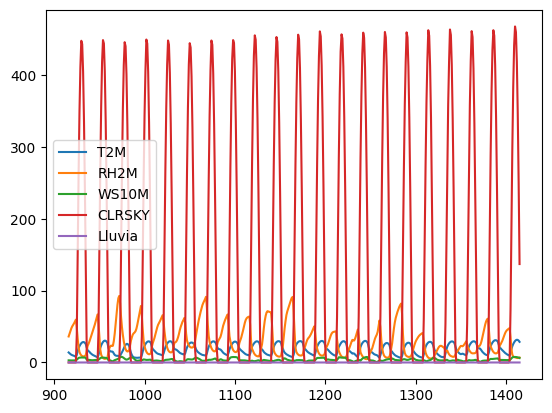

In [6]:
cols = list(df)[2:8]  #aunque usaremos los datos c/numero ascendente no los incluiremos
                    #en la grafica para que no haga pequeña las otras variables
df_for_training = df[cols].astype(float)
df_for_plot = df_for_training.tail(1150)

                    
cols2 = list(df)[3:8]     #graficamos las var. d'entrada c/numDato en las "x"
df_for_training2 = df[cols2].astype(float)
df_for_plot2 = df_for_training2.tail(500)
df_for_plot2.plot.line()
#df_for_plot2

In [7]:
df_for_training.head(10)  #Separamos las var. d'entrada en df_for_training

,NumDato,T2M,RH2M,WS10M,CLRSKY,Lluvia
0,1.0,14.95,45.19,2.70,4.55,0.0
1,2.0,13.95,46.38,2.61,0.00,0.0
2,3.0,13.69,45.31,2.32,0.00,0.0
3,4.0,12.95,46.38,2.33,0.00,0.0
4,5.0,11.40,51.19,2.74,0.00,0.0
5,6.0,9.99,55.50,3.05,0.00,0.0
6,7.0,9.23,58.00,3.15,0.00,0.0
7,8.0,8.54,60.75,3.02,0.00,0.0
8,9.0,8.17,62.44,2.77,0.00,0.0
9,10.0,7.93,63.69,2.57,0.00,0.0


La LSTM usa como funcion de disparo la sigmoide y la tanh que son sensibles a la magnitud
Así que los valores necesitan ser normalizados 

Normalizando la BD

In [8]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [9]:
df_for_training_scaled[:10]

array([[-1.73082804, -0.26012193,  0.15528694, -0.39418891, -0.74469495,
        -0.18273214],
       [-1.72838164, -0.39721675,  0.2058534 , -0.45132333, -0.77266066,
        -0.18273214],
       [-1.72593524, -0.43286141,  0.16038608, -0.63542311, -0.77266066,
        -0.18273214],
       [-1.72348884, -0.53431158,  0.2058534 , -0.62907484, -0.77266066,
        -0.18273214],
       [-1.72104244, -0.74680855,  0.41024385, -0.36879584, -0.77266066,
        -0.18273214],
       [-1.71859604, -0.94011225,  0.59338789, -0.17199952, -0.77266066,
        -0.18273214],
       [-1.71614964, -1.04430431,  0.69961994, -0.10851683, -0.77266066,
        -0.18273214],
       [-1.71370324, -1.13889974,  0.81647519, -0.19104432, -0.77266066,
        -0.18273214],
       [-1.71125684, -1.18962482,  0.88828805, -0.34975103, -0.77266066,
        -0.18273214],
       [-1.70881044, -1.22252758,  0.94140407, -0.4767164 , -0.77266066,
        -0.18273214]])

P/LSTM se requiere re-formar (reshape) un dato d entrada en n_muestras x pasosdetiempo
En este ejemplo, las n_caracteristicas son 6. Haremos  pasosdetiempo=24 (un día ya que 
se toma una muestra c/hora).  Con esto, las n_muestras resultantes son 24 

In [10]:
trainX = []
trainY = []

n_future = 12  # No. de muestras que quiero predecir en el futuro
n_past = 24    #No. muestras pasadas que elijo para predecir los n_future muestras del futuro

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i-n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i+n_future-1:i + n_future, 0])

TExto

In [11]:
trainX, trainY = np.array(trainX), np.array(trainY)

Desplegar como se ve trainX, df_for_training_escaled y trainY  en los primeros 
30 datos para entender como se realiza el entrenamiento con los 1os 24 datos
y luego los 12 siguiente es la salida a predecir.

In [12]:
trainX.shape # Note que trainX tiene 1381 filas, vectores de 24 elementos y 6 variables

(1381, 24, 6)

In [13]:
df_for_training_scaled.shape # tiene 1416 filas, vectores de 6 elementos 35 más que trainX

(1416, 6)

In [14]:
trainY.shape # Note que trainY tiene 1381 filas, vectores de 1 elementos

(1381, 1)

In [15]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

2026-01-14 19:26:59.605312: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/home/virgilio/Documentos/pythonProys/TimeSeriesRegression/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,625 (119.63 KB)

 Trainable params: 30,625 (119.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(trainX, trainY, epochs=250, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/500
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.3329 - val_loss: 0.0701
Epoch 2/500
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0359 - val_loss: 0.0057
Epoch 3/500
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0245 - val_loss: 0.0075
Epoch 4/500
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0286 - val_loss: 0.0041
Epoch 5/500
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0243 - val_loss: 0.0232
Epoch 6/500
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0208 - val_loss: 0.0082
Epoch 7/500
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0196 - val_loss: 0.0073
Epoch 8/500
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0229 - val_loss: 0.0170
Epoch 9/500
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0201 - val_loss: 0.0031
Epoch 10/500
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0198 - val_loss: 0.0085
Epoch 11/500
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0154 - val_loss: 0.0041
Epoch 12/500
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.

Para ver como se comporto el entrenamiento durante el aprendizaje

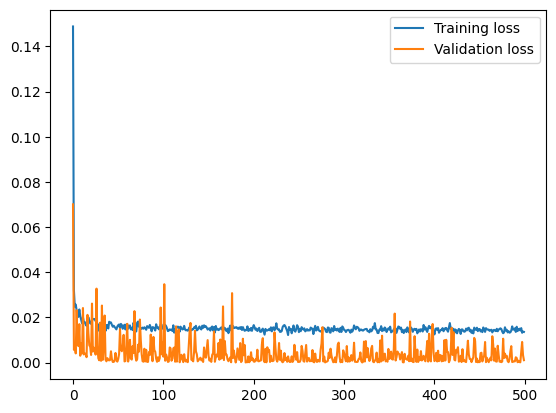

In [17]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

Se obtiene un buen valor de error MSE 

In [18]:
n_future = 90
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future, freq='1d').tolist()
forecast = model.predict(trainX[-n_future:]) #forecast

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


In [ ]:
#forecast_period_dates

In [ ]:
#forecast

Dado que se escalo (scaler) podriamos utilizar la transformada inversa, pero no funcionará
debido a que operó con 5 variables y actualmente forecast es de (90,1).

In [ ]:
#y_pred_future = scaler.inverse_transform(forecast) #Solo para ver que no funciona

En vez de lo anterior

In [19]:
forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

In [ ]:
#forecast_copies

In [ ]:
#y_pred_future

In [20]:
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date()) #########################################################################

In [21]:
forecast_dates

[datetime.date(2022, 3, 30),
 datetime.date(2022, 3, 31),
 datetime.date(2022, 4, 1),
 datetime.date(2022, 4, 2),
 datetime.date(2022, 4, 3),
 datetime.date(2022, 4, 4),
 datetime.date(2022, 4, 5),
 datetime.date(2022, 4, 6),
 datetime.date(2022, 4, 7),
 datetime.date(2022, 4, 8),
 datetime.date(2022, 4, 9),
 datetime.date(2022, 4, 10),
 datetime.date(2022, 4, 11),
 datetime.date(2022, 4, 12),
 datetime.date(2022, 4, 13),
 datetime.date(2022, 4, 14),
 datetime.date(2022, 4, 15),
 datetime.date(2022, 4, 16),
 datetime.date(2022, 4, 17),
 datetime.date(2022, 4, 18),
 datetime.date(2022, 4, 19),
 datetime.date(2022, 4, 20),
 datetime.date(2022, 4, 21),
 datetime.date(2022, 4, 22),
 datetime.date(2022, 4, 23),
 datetime.date(2022, 4, 24),
 datetime.date(2022, 4, 25),
 datetime.date(2022, 4, 26),
 datetime.date(2022, 4, 27),
 datetime.date(2022, 4, 28),
 datetime.date(2022, 4, 29),
 datetime.date(2022, 4, 30),
 datetime.date(2022, 5, 1),
 datetime.date(2022, 5, 2),
 datetime.date(2022, 5, 3

In [ ]:

df_forecast = pd.DataFrame({'Fecha':np.array(forecast_dates), 'Potencia':y_pred_future})
df_forecast['Fecha']=pd.to_datetime(df_forecast['Fecha'])
df_forecast

,Fecha,Open
0,2022-03-30,1316.026001
1,2022-03-31,1313.785156
2,2022-04-01,1312.519165
3,2022-04-02,1312.524170
4,2022-04-03,1312.495361
...,...,...
85,2022-06-23,1394.631226
86,2022-06-24,1396.597656
87,2022-06-25,1398.585938
88,2022-06-26,1400.197510


/tmp/ipykernel_11216/3249516796.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Fecha'] = pd.to_datetime(original['Fecha'])


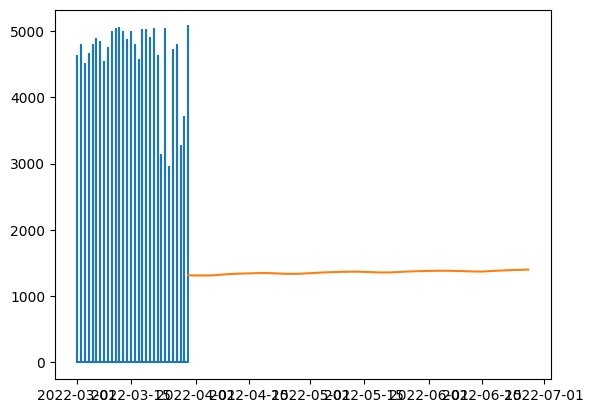

In [ ]:
original = df[['Fecha', 'WH']] # Ahora recuperemos de la BD original la fecha y WH
original['Fecha'] = pd.to_datetime(original['Fecha'])
original = original.loc[original['Fecha'] >='2022-03-01']

#sns.lineplot(original['Fecha'], original['WH'])
#sns.lineplot(df_forecast['Fecha'], df_forecast['Open'])

plt.plot(original['Fecha'], original['WH'])
plt.plot(df_forecast['Fecha'], df_forecast['Potencia'])
    

Falta corregir el error anterior para que la grafica sea más ilustrativa